# Exploratorio de Datos - Mercado Laboral, Economia y educacion

## Importar librerias y otras cosas utiles 

In [1]:
# Importar librerias

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
%matplotlib inline 
# display para mi merge

class display(object):
    """Display HTML representation of multiple objects"""
    template = """<div style="float: left; padding: 10px;">
    <p style='font-family:"Courier New", Courier, monospace'>{0}</p>{1}
    </div>"""
    def __init__(self, *args):
        self.args = args
        
    def _repr_html_(self):
        return '\n'.join(self.template.format(a, eval(a)._repr_html_())
                         for a in self.args)
    
    def __repr__(self):
        return '\n\n'.join(a + '\n' + repr(eval(a))
                           for a in self.args)

!pip install --upgrade pandas


Requirement already up-to-date: pandas in /opt/anaconda3/lib/python3.8/site-packages (1.1.4)


## Cargar el dataset y limpiarlo 

In [2]:
df = pd.read_csv('data/CP_national_en.csv', index_col = 0) # cargar datos, columna Country indice para evitrar uffef
df['Country'] = df.index.values       #Columna nueva con los valores del indice Country
df.index = list(range(len(df)))       #indice nuevo
first_col = df.pop('Country')       # saco la columna indice...
df.insert(0, 'Country', first_col, allow_duplicates = True)      # ...para insertarla a la cabeza

# ya tengo mi dataframe

df_original = df.copy()  # no trabajar con df original, pero dejarlo subido

df.drop(['Notes', 'More'], axis = 1, inplace = True)

# 

df = df.melt(id_vars=['Country', 'Indicator'], value_vars=['Total', 'Men', 'Women']) #melt 
df['Indicator'] = df['Indicator'] + ", " + df['variable']
df.drop(columns = 'variable', inplace = True)
df.drop_duplicates(subset=['Country', 'Indicator'], inplace=True)    #duplicados
df = df.pivot(index='Country', columns='Indicator', values= 'value')   #pivot

## Cargar el dataset del world bank y limpiarlo (muy preliminar)

count    137.000000
mean       0.390600
std        0.412243
min        0.000000
25%        0.000000
50%        0.219512
75%        0.756098
max        1.000000
Name: Null columns (%), dtype: float64


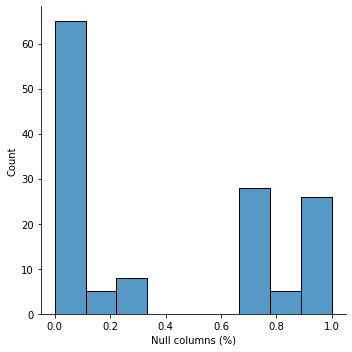

In [3]:
pisa = pd.read_excel('data/PISA.xlsx')
wdi = pd.read_excel('data/WDI.xlsx')
worldbank = pd.merge(pisa, wdi, on = 'Country Code')
worldbank.replace(to_replace = "..", value = np.nan, inplace = True )
worldbank.drop(labels = 'Country Name_y', axis = 1, inplace = True)
worldbank.iloc[:,4:] = worldbank.iloc[:,4:].apply(pd.to_numeric)
worldbank.rename({"Country Name_x" : 'Country'}, axis = 1, inplace = True)
worldbank.drop(columns = ['Time Code', 'Time'], inplace = True)



# Sacar el % de valores nulos por pais
worldbank['Null columns (%)'] = worldbank.isnull().sum(axis=1)/len(worldbank.columns[2:]) 
worldbank[['Country', 'Null columns (%)']].sort_values('Null columns (%)', ascending = True)


sns.displot(worldbank, x= 'Null columns (%)');
print(worldbank['Null columns (%)'].describe())

#Me quedo con los paises que tienen mas datos

worldbank = worldbank[worldbank['Null columns (%)'] < 0.4]

# Anado poblacion
popu = pd.read_excel('data/population.xlsx')
popu.drop(columns = 'drop', inplace = True)

worldbank = pd.merge(worldbank, popu, on = 'Country Code')

worldbank.drop(columns = 'Country Name', inplace = True)

worldbank['Population, total [SP.POP.TOTL]'] = worldbank['Population, total [SP.POP.TOTL]'].apply(pd.to_numeric)

# reseteo el index

worldbank.index = np.arange(len(worldbank))

# borrar mierda
del df_original



## Sacar dfs definitivos

In [6]:
#necesitan clave comun (codigos)

codigos = pd.read_excel('varios/paisesOIT.xlsx')
codigos.drop(index = 209, inplace = True)

oit = pd.merge(df, codigos, left_index = True, right_on = 'Country')

df = pd.merge(oit, worldbank, right_on = 'Country Code', left_on = 'Code')
df[['Code', 'Country_x', 'Country_y', 'Country Code']]
df.drop(columns = ['Country_y', 'Country Code'], inplace = True)

# pasar columnas de nombres y codigos al principio
first_col = df.pop('Country_x')
second_col = df.pop('Code')
df.insert(0, 'Country', first_col)
df.insert(0, 'Code', second_col)

# eliminar columnas innecesarias (local currencies ppalmente)

df.drop(columns = ['Average hourly labour cost per employee, local currency, Men',
                    'Average hourly labour cost per employee, local currency, Total',
                    'Average hourly labour cost per employee, local currency, Women',
                    'Average monthly earnings of employees, local currency, Men',
                    'Average monthly earnings of employees, local currency, Total',
                    'Average monthly earnings of employees, local currency, Women',
                    'Monthly minimum wage, local currency, Men',
                    'Monthly minimum wage, local currency, Total',
                    'Monthly minimum wage, local currency, Women',
                    'Null columns (%)'], inplace = True)

# ordenar columnas, metodo muy chulo

cols_to_order = ['Code', 
                 'Country', 
                 'Population, total [SP.POP.TOTL]', 
                 'Adjusted net national income per capita (constant 2010 US$) [NY.ADJ.NNTY.PC.KD]',
                 'Gini index (World Bank estimate) [SI.POV.GINI]']
new_columns = cols_to_order + (df.columns.drop(cols_to_order).tolist())
df = df[new_columns]

# crear indice PISA con maths,science y reading
df['PISA Index Mean'] = df['PISA: Mean performance on the reading scale [LO.PISA.REA]']*(1/3)\
                        +df['PISA: Mean performance on the science scale [LO.PISA.SCI]']*(1/3)\
                        +df['PISA: Mean performance on the mathematics scale [LO.PISA.MAT]']*(1/3)

# indice                   
df.set_index(["Code",
                "Country"], inplace = True)

# multiindexar las columnas del df en funcion de si la variable corresponde a hombres, mujeres o total

columnas = [("Total","Population, total"),
    ("Total","Adjusted net national income per capita (constant 2010 US$) [NY.ADJ.NNTY.PC.KD]"),
    ("Total","Gini index"),
    ("Men","Average weekly hours actually worked per employed person, Men"),
    ("Total","Average weekly hours actually worked per employed person, Total"),
    ("Women","Average weekly hours actually worked per employed person, Women"),
    ("Men","Collective bargaining coverage rate (%), Men"),
    ("Total","Collective bargaining coverage rate (%), Total"),
    ("Women","Collective bargaining coverage rate (%), Women"),
    ("Men","Employment-population ratio (%), Men"),
    ("Total","Employment-population ratio (%), Total"),
    ("Women","Employment-population ratio (%), Women"),
    ("Men","Incidence rate of non-fatal occupational injuries (per 100'000 in reference group), Men"),
    ("Total","Incidence rate of non-fatal occupational injuries (per 100'000 in reference group), Total"),
    ("Women","Incidence rate of non-fatal occupational injuries (per 100'000 in reference group), Women"),
    ("Men","Incidence rate of occupational fatalities (per 100'000 in reference group), Men"),
    ("Total","Incidence rate of occupational fatalities (per 100'000 in reference group), Total"),
    ("Women","Incidence rate of occupational fatalities (per 100'000 in reference group), Women"),
    ("Men","LU3: Combined rate of unemployment and potential labour force (%), Men"),
    ("Total","LU3: Combined rate of unemployment and potential labour force (%), Total"),
    ("Women","LU3: Combined rate of unemployment and potential labour force (%), Women"),
    ("Men","LU4: Composite rate of labour underutilization (%), Men"),
    ("Total","LU4: Composite rate of labour underutilization (%), Total"),
    ("Women","LU4: Composite rate of labour underutilization (%), Women"),
    ("Men","Labour force participation rate (%), Men"),
    ("Total","Labour force participation rate (%), Total"),
    ("Women","Labour force participation rate (%), Women"),
    ("Men","Population covered by at least one social protection benefit (%), Men"),
    ("Total","Population covered by at least one social protection benefit (%), Total"),
    ("Women","Population covered by at least one social protection benefit (%), Women"),
    ("Men","Share of agriculture (%), Men"),
    ("Total","Share of agriculture (%), Total"),
    ("Women","Share of agriculture (%), Women"),
    ("Men","Share of employed working more than 48 hours per week (%), Men"),
    ("Total","Share of employed working more than 48 hours per week (%), Total"),
    ("Women","Share of employed working more than 48 hours per week (%), Women"),
    ("Men","Share of industry (%), Men"),
    ("Total","Share of industry (%), Total"),
    ("Women","Share of industry (%), Women"),
    ("Men","Share of informal employment -- Harmonized series (%), Men"),
    ("Total","Share of informal employment -- Harmonized series (%), Total"),
    ("Women","Share of informal employment -- Harmonized series (%), Women"),
    ("Men","Share of managers, professionals (incl. associates) and technicians (%), Men"),
    ("Total","Share of managers, professionals (incl. associates) and technicians (%), Total"),
    ("Women","Share of managers, professionals (incl. associates) and technicians (%), Women"),
    ("Men","Share of services (%), Men"),
    ("Total","Share of services (%), Total"),
    ("Women","Share of services (%), Women"),
    ("Men","Share of youth not in employment, education or training (%), Men"),
    ("Total","Share of youth not in employment, education or training (%), Total"),
    ("Women","Share of youth not in employment, education or training (%), Women"),
    ("Men","Trade union density rate (%), Men"),
    ("Total","Trade union density rate (%), Total"),
    ("Women","Trade union density rate (%), Women"),
    ("Men","Unemployment rate (%), Men"),
    ("Total","Unemployment rate (%), Total"),
    ("Women","Unemployment rate (%), Women"),
    ("Men","Unemployment rate, youth (%), Men"),
    ("Total","Unemployment rate, youth (%), Total"),
    ("Women","Unemployment rate, youth (%), Women"),
    ("Women","PISA: Mean performance on the science scale. Female [LO.PISA.SCI.FE]"),
    ("Men","PISA: Mean performance on the reading scale. Male [LO.PISA.REA.MA]"),
    ("Women","PISA: Mean performance on the mathematics scale. Female [LO.PISA.MAT.FE]"),
    ("Total","PISA: Mean performance on the reading scale [LO.PISA.REA]"),
    ("Total","PISA: Mean performance on the mathematics scale [LO.PISA.MAT]"),
    ("Men","PISA: Mean performance on the mathematics scale. Male [LO.PISA.MAT.MA]"),
    ("Women","PISA: Mean performance on the reading scale. Female [LO.PISA.REA.FE]"),
    ("Total","PISA: Mean performance on the science scale [LO.PISA.SCI]"),
    ("Men","PISA: Mean performance on the science scale. Male [LO.PISA.SCI.MA]"),
    ("Total","PISA: Distribution of Mathematics Scores: 50th Percentile Score [LO.PISA.MAT.P50]"),
    ("Total","PISA: Distribution of Mathematics Scores: 75th Percentile Score [LO.PISA.MAT.P75]"),
    ("Total","PISA: Distribution of Mathematics Scores: 10th Percentile Score [LO.PISA.MAT.P10]"),
    ("Total","PISA: Distribution of Mathematics Scores: 95th Percentile Score [LO.PISA.MAT.P95]"),
    ("Total","PISA: Distribution of Mathematics Scores: 25th Percentile Score [LO.PISA.MAT.P25]"),
    ("Total","PISA: Distribution of Mathematics Scores: 5th Percentile Score [LO.PISA.MAT.P05]"),
    ("Total","PISA: Distribution of Mathematics Scores: 90th Percentile Score [LO.PISA.MAT.P90]"),
    ("Total","PISA: Distribution of Reading Scores: 10th Percentile Score [LO.PISA.REA.P10]"),
    ("Total","PISA: Distribution of Reading Scores: 50th Percentile Score [LO.PISA.REA.P50]"),
    ("Total","PISA: Distribution of Reading Scores: 75th Percentile Score [LO.PISA.REA.P75]"),
    ("Total","PISA: Distribution of Reading Scores: 25th Percentile Score [LO.PISA.REA.P25]"),
    ("Total","PISA: Distribution of Reading Scores: 5th Percentile Score [LO.PISA.REA.P05]"),
    ("Total","PISA: Distribution of Reading Scores: 90th Percentile Score [LO.PISA.REA.P90]"),
    ("Total","PISA: Distribution of Science Scores: 95th Percentile Score [LO.PISA.SCI.P95]"),
    ("Total","PISA: Distribution of Science Scores: 75th Percentile Score [LO.PISA.SCI.P75]"),
    ("Total","PISA: Distribution of Science Scores: 50th Percentile Score [LO.PISA.SCI.P50]"),
    ("Total","PISA: Distribution of Science Scores: 10th Percentile Score [LO.PISA.SCI.P10]"),
    ("Total","PISA: Distribution of Reading Scores: 95th Percentile Score [LO.PISA.REA.P95]"),
    ("Total","PISA: Distribution of Science Scores: 25th Percentile Score [LO.PISA.SCI.P25]"),
    ("Total","PISA: Distribution of Science Scores: 5th Percentile Score [LO.PISA.SCI.P05]"),
    ("Total","PISA: Distribution of Science Scores: 90th Percentile Score [LO.PISA.SCI.P90]"),
    ("Total","Labor force with advanced education (% of total working-age population with advanced education) [SL.TLF.ADVN.ZS]"),
    ("Women","Labor force with advanced education, female (% of female working-age population with advanced education) [SL.TLF.ADVN.FE.ZS]"),
    ("Men","Labor force with advanced education, male (% of male working-age population with advanced education) [SL.TLF.ADVN.MA.ZS]"),
    ("Total","Labor force with basic education (% of total working-age population with basic education) [SL.TLF.BASC.ZS]"),
    ("Women","Labor force with basic education, female (% of female working-age population with basic education) [SL.TLF.BASC.FE.ZS]"),
    ("Men","Labor force with basic education, male (% of male working-age population with basic education) [SL.TLF.BASC.MA.ZS]"),
    ("Total","Labor force with intermediate education (% of total working-age population with intermediate education) [SL.TLF.INTM.ZS]"),
    ("Women","Labor force with intermediate education, female (% of female working-age population with intermediate education) [SL.TLF.INTM.FE.ZS]"),
    ("Men","Labor force with intermediate education, male (% of male working-age population with intermediate education) [SL.TLF.INTM.MA.ZS]"),
    ("Total","PISA Index Mean")]

df.columns = pd.MultiIndex.from_tuples(columnas)

# cross section para tener 3 df: uno de mujeres, uno de hombres, uno total
dftotales = df.xs('Total', axis=1, level=0)
dfhombres = df.xs('Men', axis=1, level=0)
dfmujeres = df.xs('Women', axis=1, level=0)

dftotales.reset_index(level=['Country'], inplace = True)
dfhombres.reset_index(level=['Country'], inplace = True)
dfmujeres.reset_index(level=['Country'], inplace = True)

# drop, muchos missings
dftotales.drop(columns = "Share of informal employment -- Harmonized series (%), Total", inplace = True)

#arreglar el missing de Espana
dftotales.at['ESP', 'PISA Index Mean'] = \
dftotales[dftotales['Country'] == 'Spain']['PISA: Mean performance on the mathematics scale [LO.PISA.MAT]']*0.5 + \
dftotales[dftotales['Country'] == 'Spain']['PISA: Mean performance on the science scale [LO.PISA.SCI]']*0.5


# anadir continentes

continentes= pd.Series(["EUR",
                        "SA",
                        "OC",
                        "EUR",
"EUR",
"EUR",
"EUR",
"SA",
"AS",
"EUR",
"NA",
"SA",
"AS",
"SA",
"CA",
"EUR",
"EUR",
"EUR",
"EUR",
"CA",
"EUR",
"EUR",
"EUR",
"EUR",
"EUR",
"EUR",
"AS",
"EUR",
"EUR",
"AS",
"EUR",
"ME",
"EUR",
"AS",
"ME",
"AS",
"AS",
"EUR",
"EUR",
"ME",
"EUR",
"EUR",
"AS",
"AS",
"EUR",
"CA",
"EUR",
"EUR",
"AF",
"EUR",
"OC",
"EUR",
"EUR",
"CA",
"SA",
"AS",
"EUR",
"EUR",
"ME",
"EUR",
"EUR",
"ME",
"EUR",
"AS",
"EUR",
"EUR",
"EUR",
"EUR",
"EUR",
"AS",
"ME",
"EUR",
"ME",
"EUR",
"NA",
"SA",
"AS"])

dftotales['Continent'] = continentes.values

conts = dftotales.pop('Continent')
dftotales.insert(0, 'Continent', conts)

# China engana, resultados para una region pero todas las demas variables para pais en general
dftotales.drop(index = 'CHN', inplace = True)



/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4167: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(
<ipython-input-6-c4b1ccfb94f2>:253: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dftotales['Continent'] = continentes.values


## Columnas y missings por columnas

In [ ]:
# Missings por columna
for i in dftotales.columns:
    print(i, "\n", sum(dftotales[i].isnull())/len(dftotales), "\n")


In [ ]:
# works
for i in df.columns[3:60]:
    if "Total" in str(i):
        print('("Total",'+ str('"')+i+str('"')+str(")")+str(","))
    elif "Men" in str(i):
        print('("Men",'+ str('"')+i+str('"')+str(")")+str(","))
    elif "Women" in str(i):
        print('("Women",'+ str('"')+i+str('"')+str(")")+str(","))
# not quite
for i in df.columns[60:-1]:
    if ("Male" or "male") in str(i):
        print('("Men",'+ str('"')+i+str('"')+str(")")+str(","))
    elif ("Female" or "female") in str(i):
        print('("Women",'+ str('"')+i+str('"')+str(")")+str(","))
        


# Visualizaciones:

## Info general sobre el sample

In [ ]:
sns.set_style("whitegrid")
plt.style.use("classic")

In [7]:
# Sacar estadisticos 
resumenmuestra = dftotales.describe().transpose()
#Algunos estadisticos de los paises de nuestra muestra a anadir en mi dash
resumenmuestra.loc[['Population, total',
                    'Adjusted net national income per capita (constant 2010 US$) [NY.ADJ.NNTY.PC.KD]',
                   'PISA: Mean performance on the reading scale [LO.PISA.REA]',
                    'PISA: Mean performance on the mathematics scale [LO.PISA.MAT]',
                    'PISA: Mean performance on the science scale [LO.PISA.SCI]'],
                   ['mean', "50%"]]

,mean,50%
"Population, total",3.468605e+07,9.770239e+06
Adjusted net national income per capita (constant 2010 US$) [NY.ADJ.NNTY.PC.KD],2.132798e+04,1.414639e+04
PISA: Mean performance on the reading scale [LO.PISA.REA],4.526150e+02,4.659501e+02
PISA: Mean performance on the mathematics scale [LO.PISA.MAT],4.569722e+02,4.679643e+02
PISA: Mean performance on the science scale [LO.PISA.SCI],4.573278e+02,4.681557e+02


## Mapas paises que tenemos: para Dash
### -Mapa income

In [ ]:
fig = px.choropleth(dftotales, locations=dftotales.index,
                    color="Adjusted net national income per capita (constant 2010 US$) [NY.ADJ.NNTY.PC.KD]", 
                    hover_name=dftotales.index, 
                    color_continuous_scale='Burg',
                   title = "Adjusted net national income per capita (constant 2010 US$)",
                   labels = {"Adjusted net national income per capita (constant 2010 US$) [NY.ADJ.NNTY.PC.KD]" : "US$"},
                   width=1500, height=900)
fig.show()


### -Mapa PISA

In [ ]:
fig = px.choropleth(dftotales, locations=dftotales.index.get_level_values(0),
                    color="PISA Index Mean", # lifeExp is a column of gapminder
                    hover_name=dftotales.index.get_level_values(1), # column to add to hover information
                    color_continuous_scale='Burg')
fig.show()

## -Tabla results PISA

In [ ]:
trace1 = go.Bar(x = dftotales.sort_values('PISA Index Mean', ascending = True)['PISA Index Mean'].values,
               y = dftotales.sort_values('PISA Index Mean', ascending = True).index,
                orientation= "h",
                name = 'Total sales by state, 2014',
                marker = dict(color = 'rgba(200, 100, 5, 0.5)',
                             line = dict(color = 'rgb(0, 0, 0)',
                                        width = 1.5))
               )


data = [trace1]
layout = go.Layout(barmode = "group",
                  title = 'PISA Index Mean')
fig3 = go.Figure(data = data, layout = layout)
fig3.update_xaxes(tickangle = 0)


In [ ]:
# ranking pisa
plt.figure(figsize = (60,40))
sns.barplot(data = dftotales.sort_values('PISA Index Mean', ascending = False),
           y = dftotales.sort_values('PISA Index Mean', ascending = False).index,
           x = 'PISA Index Mean',
           color = 'green')

# para el dash, ya esta hecho mejor

## Correlaciones

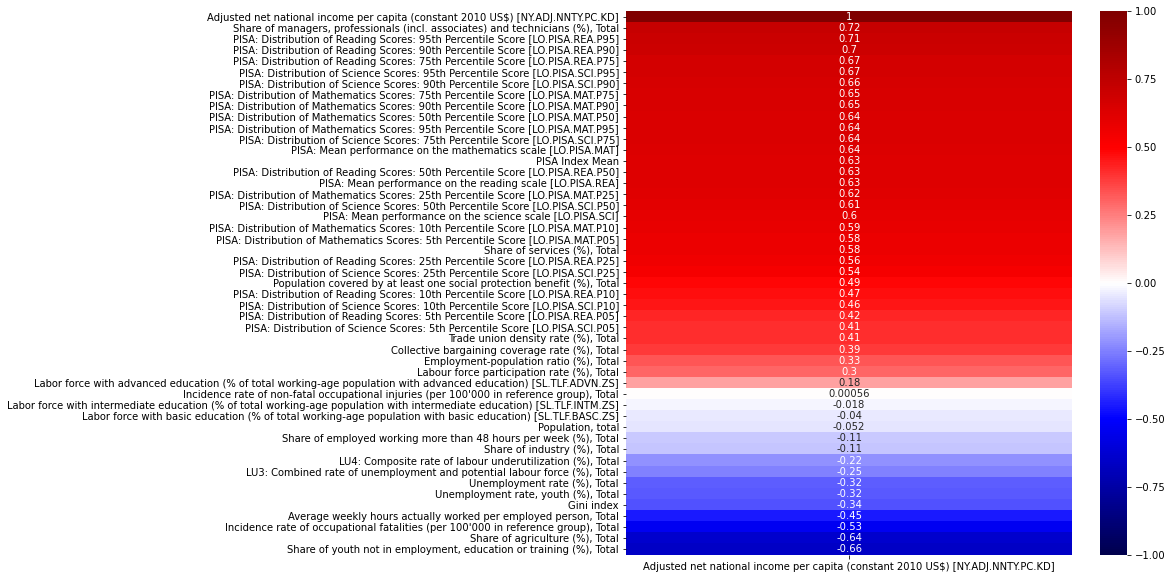

In [8]:
# correlaciones con ingresos
plt.figure(figsize=(10,10))
sns.heatmap(dftotales.corr()\
[['Adjusted net national income per capita (constant 2010 US$) [NY.ADJ.NNTY.PC.KD]']]\
.sort_values('Adjusted net national income per capita (constant 2010 US$) [NY.ADJ.NNTY.PC.KD]', ascending = False),
           vmin = -1,
           vmax = 1,
           center = 0,
           cmap = 'seismic',
           annot = True,)

Text(0.5, 1.0, 'Correlacion Ingresos per capita - Resultados PISA')

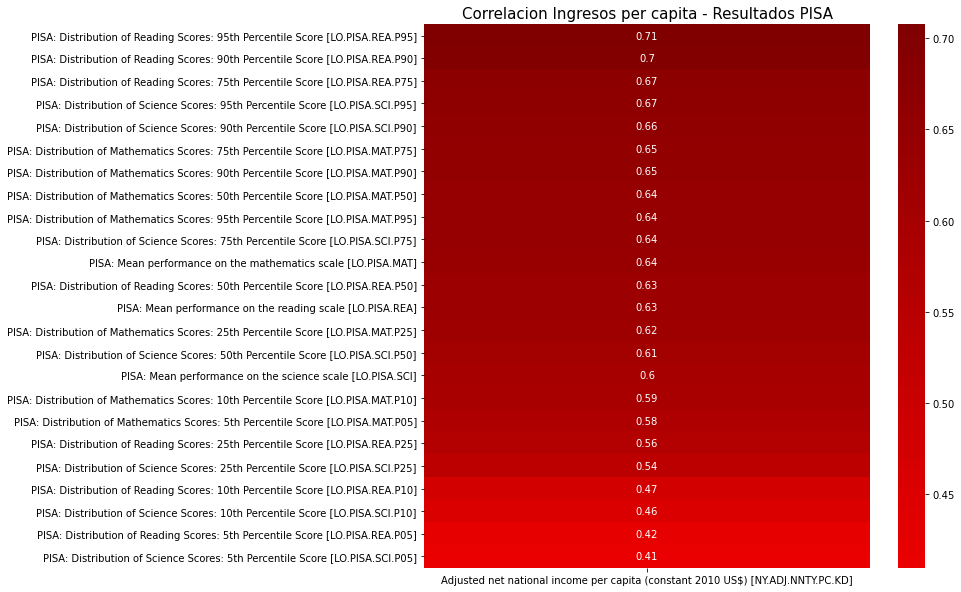

In [9]:
# Income correlates much more strongly with higher percentiles of results
plt.figure(figsize=(10,10))
sns.heatmap(dftotales[['Adjusted net national income per capita (constant 2010 US$) [NY.ADJ.NNTY.PC.KD]',
           'PISA: Mean performance on the reading scale [LO.PISA.REA]',
"PISA: Mean performance on the mathematics scale [LO.PISA.MAT]",
'PISA: Mean performance on the science scale [LO.PISA.SCI]',
'PISA: Distribution of Mathematics Scores: 50th Percentile Score [LO.PISA.MAT.P50]',
'PISA: Distribution of Mathematics Scores: 75th Percentile Score [LO.PISA.MAT.P75]',
'PISA: Distribution of Mathematics Scores: 10th Percentile Score [LO.PISA.MAT.P10]',
'PISA: Distribution of Mathematics Scores: 95th Percentile Score [LO.PISA.MAT.P95]',
'PISA: Distribution of Mathematics Scores: 25th Percentile Score [LO.PISA.MAT.P25]',
'PISA: Distribution of Mathematics Scores: 5th Percentile Score [LO.PISA.MAT.P05]',
'PISA: Distribution of Mathematics Scores: 90th Percentile Score [LO.PISA.MAT.P90]',
'PISA: Distribution of Reading Scores: 10th Percentile Score [LO.PISA.REA.P10]',
'PISA: Distribution of Reading Scores: 50th Percentile Score [LO.PISA.REA.P50]',
'PISA: Distribution of Reading Scores: 75th Percentile Score [LO.PISA.REA.P75]',
'PISA: Distribution of Reading Scores: 25th Percentile Score [LO.PISA.REA.P25]',
'PISA: Distribution of Reading Scores: 5th Percentile Score [LO.PISA.REA.P05]',
'PISA: Distribution of Reading Scores: 90th Percentile Score [LO.PISA.REA.P90]',
'PISA: Distribution of Science Scores: 95th Percentile Score [LO.PISA.SCI.P95]',
'PISA: Distribution of Science Scores: 75th Percentile Score [LO.PISA.SCI.P75]',
'PISA: Distribution of Science Scores: 50th Percentile Score [LO.PISA.SCI.P50]',
'PISA: Distribution of Science Scores: 10th Percentile Score [LO.PISA.SCI.P10]',
'PISA: Distribution of Reading Scores: 95th Percentile Score [LO.PISA.REA.P95]',
'PISA: Distribution of Science Scores: 25th Percentile Score [LO.PISA.SCI.P25]',
'PISA: Distribution of Science Scores: 5th Percentile Score [LO.PISA.SCI.P05]',
'PISA: Distribution of Science Scores: 90th Percentile Score [LO.PISA.SCI.P90]']].corr()\
[['Adjusted net national income per capita (constant 2010 US$) [NY.ADJ.NNTY.PC.KD]']]\
.sort_values('Adjusted net national income per capita (constant 2010 US$) [NY.ADJ.NNTY.PC.KD]', ascending = False)[1:],
           center = 0,
           cmap = 'seismic',
           annot = True,)
plt.title('Correlacion Ingresos per capita - Resultados PISA',
         fontsize = 15)



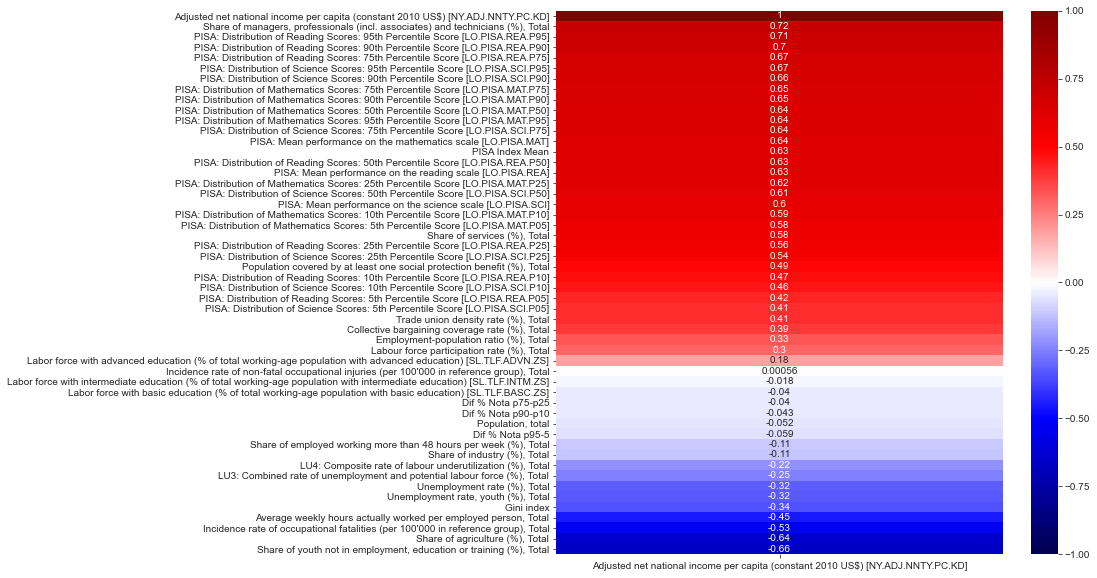

In [41]:
# Heatmap global de income
plt.figure(figsize=(10,10))
sns.heatmap(dftotales.corr()\
[['Adjusted net national income per capita (constant 2010 US$) [NY.ADJ.NNTY.PC.KD]']]\
.sort_values('Adjusted net national income per capita (constant 2010 US$) [NY.ADJ.NNTY.PC.KD]', ascending = False),
            vmin = -1,
           vmax = 1,
           center = 0,
           cmap = 'seismic',
           annot = True,)

## Correlaciones PISA

Text(0.5, 1.0, 'Correlaciones entre medias de las distintas pruebas')

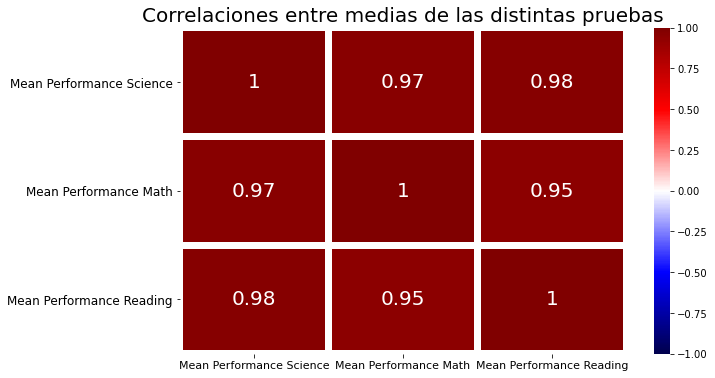

In [10]:
# Correlaciones entre las distintas pruebas
plt.figure(figsize = (10,6))

sns.heatmap(dftotales[["PISA: Mean performance on the science scale [LO.PISA.SCI]",
          "PISA: Mean performance on the mathematics scale [LO.PISA.MAT]",
           "PISA: Mean performance on the reading scale [LO.PISA.REA]"]].corr(),
           vmin = -1,
           vmax = 1,
           center = 0,
           cmap = 'seismic',
           annot = True,
           linewidths = 6,
            annot_kws={"fontsize":20},
           xticklabels = ['Mean Performance Science',
                         'Mean Performance Math',
                         'Mean Performance Reading'],
            yticklabels = ['Mean Performance Science',
                         'Mean Performance Math',
                         'Mean Performance Reading'])

plt.xticks(fontsize = 11)
plt.yticks(fontsize = 12)
plt.title('Correlaciones entre medias de las distintas pruebas',
         fontsize = 20)




In [42]:
# Correlaciones sin todos los percentiles PISA

listasi = []
listano = ['PISA: Mean performance on the reading scale [LO.PISA.REA]',
"PISA: Mean performance on the mathematics scale [LO.PISA.MAT]",
'PISA: Mean performance on the science scale [LO.PISA.SCI]',
'PISA: Distribution of Mathematics Scores: 50th Percentile Score [LO.PISA.MAT.P50]',
'PISA: Distribution of Mathematics Scores: 75th Percentile Score [LO.PISA.MAT.P75]',
'PISA: Distribution of Mathematics Scores: 10th Percentile Score [LO.PISA.MAT.P10]',
'PISA: Distribution of Mathematics Scores: 95th Percentile Score [LO.PISA.MAT.P95]',
'PISA: Distribution of Mathematics Scores: 25th Percentile Score [LO.PISA.MAT.P25]',
'PISA: Distribution of Mathematics Scores: 5th Percentile Score [LO.PISA.MAT.P05]',
'PISA: Distribution of Mathematics Scores: 90th Percentile Score [LO.PISA.MAT.P90]',
'PISA: Distribution of Reading Scores: 10th Percentile Score [LO.PISA.REA.P10]',
'PISA: Distribution of Reading Scores: 50th Percentile Score [LO.PISA.REA.P50]',
'PISA: Distribution of Reading Scores: 75th Percentile Score [LO.PISA.REA.P75]',
'PISA: Distribution of Reading Scores: 25th Percentile Score [LO.PISA.REA.P25]',
'PISA: Distribution of Reading Scores: 5th Percentile Score [LO.PISA.REA.P05]',
'PISA: Distribution of Reading Scores: 90th Percentile Score [LO.PISA.REA.P90]',
'PISA: Distribution of Science Scores: 95th Percentile Score [LO.PISA.SCI.P95]',
'PISA: Distribution of Science Scores: 75th Percentile Score [LO.PISA.SCI.P75]',
'PISA: Distribution of Science Scores: 50th Percentile Score [LO.PISA.SCI.P50]',
'PISA: Distribution of Science Scores: 10th Percentile Score [LO.PISA.SCI.P10]',
'PISA: Distribution of Reading Scores: 95th Percentile Score [LO.PISA.REA.P95]',
'PISA: Distribution of Science Scores: 25th Percentile Score [LO.PISA.SCI.P25]',
'PISA: Distribution of Science Scores: 5th Percentile Score [LO.PISA.SCI.P05]',
'PISA: Distribution of Science Scores: 90th Percentile Score [LO.PISA.SCI.P90]']

for i in dftotales.columns:
    if i not in listano:
        listasi.append(i)
    

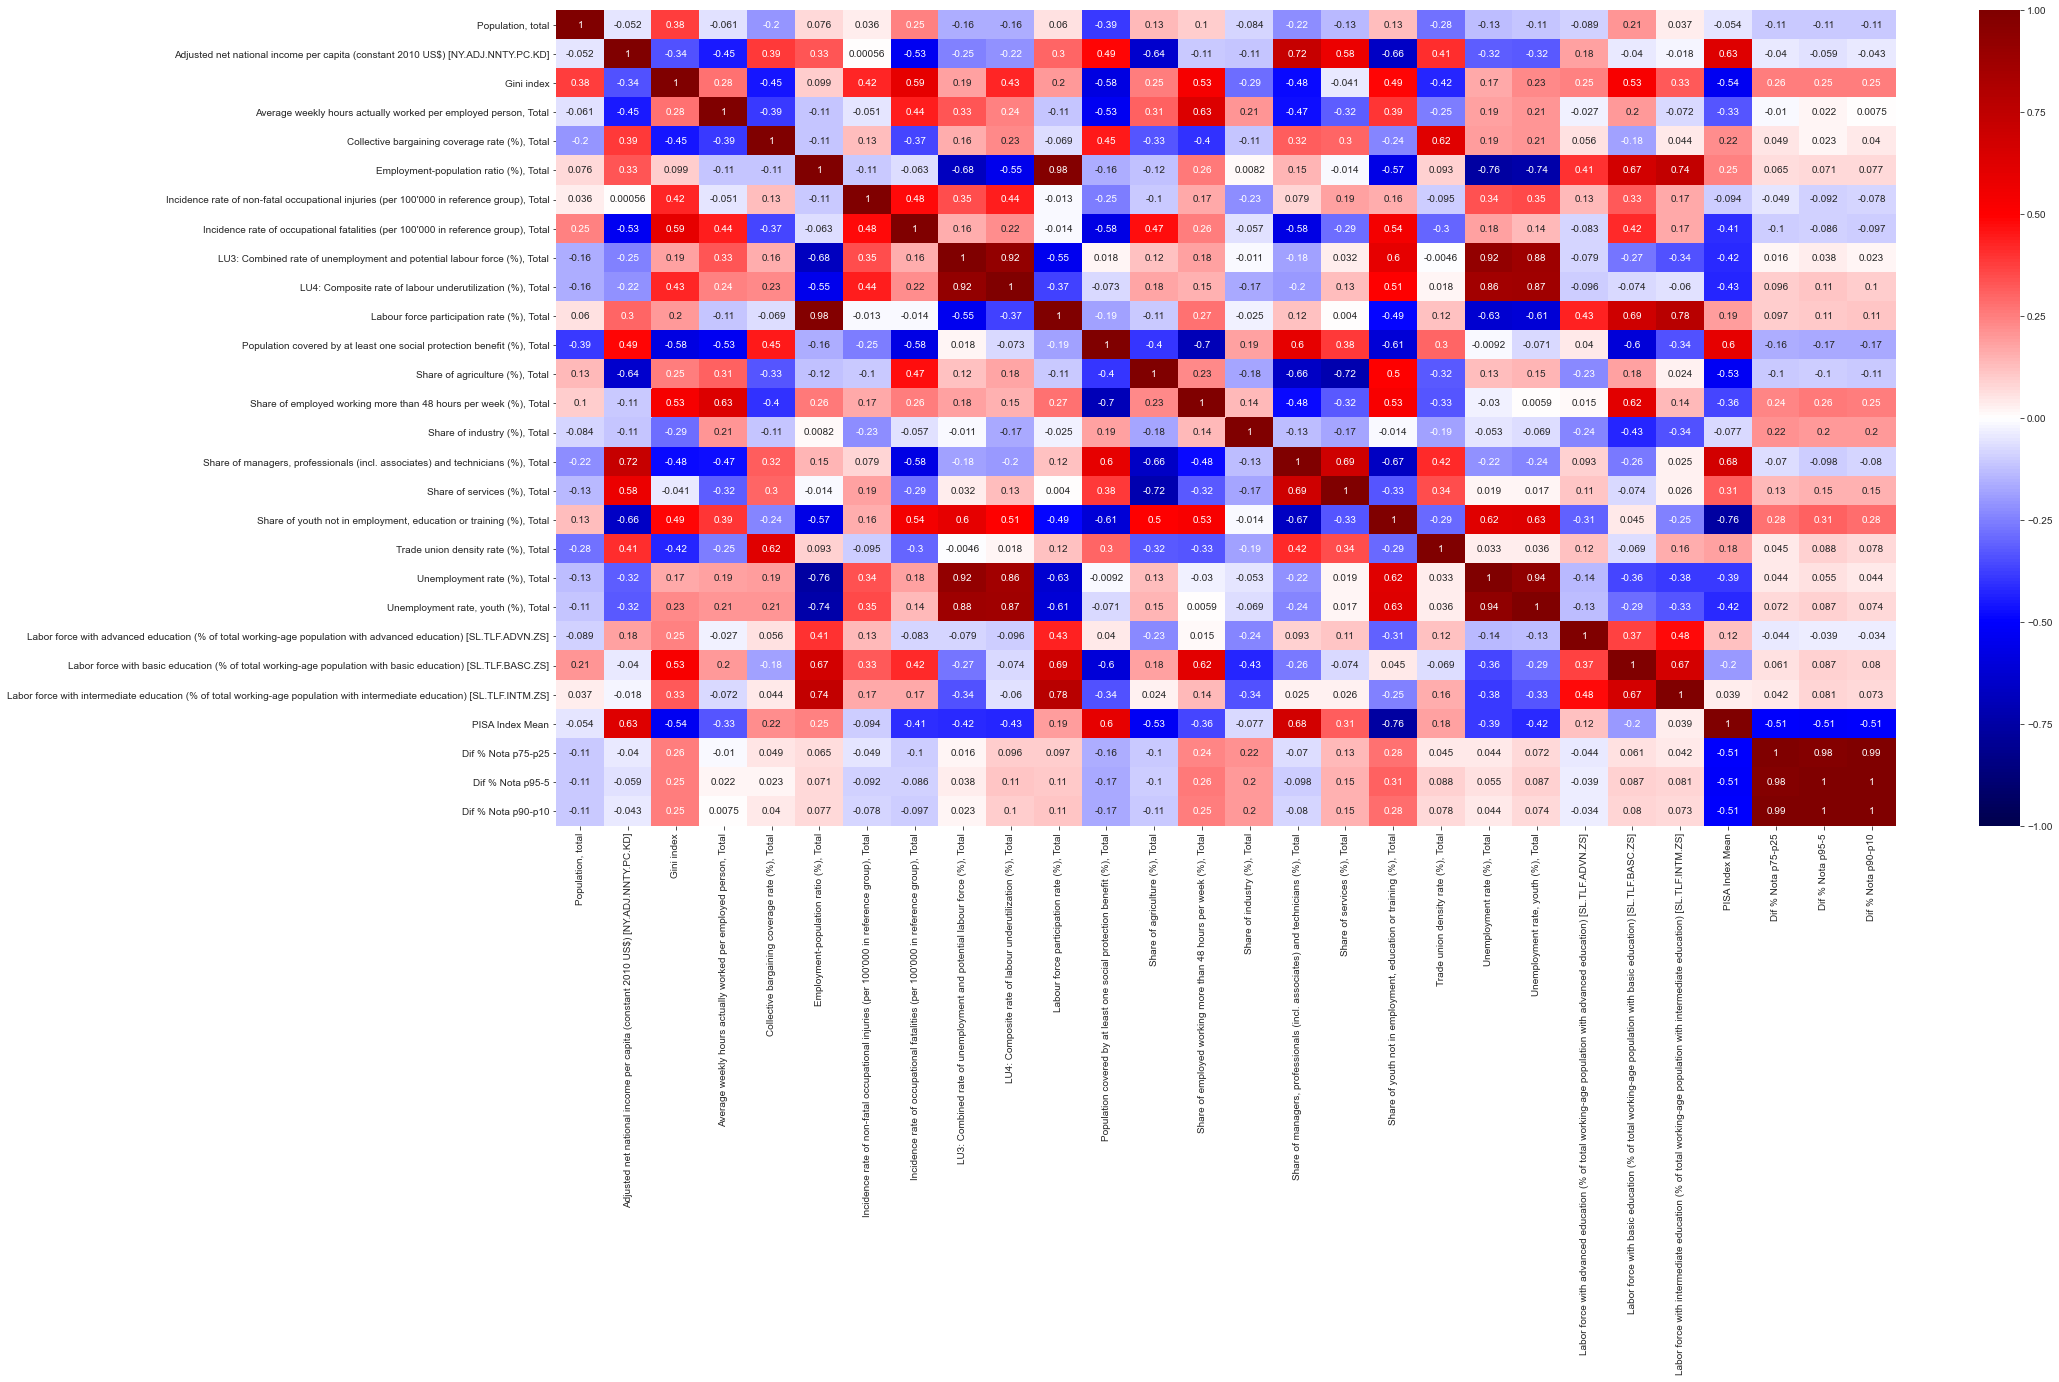

In [43]:
# Matriz correlacion general
plt.figure(figsize=(30,15))

sns.heatmap(dftotales[listasi].corr(),
           vmin = -1,
           vmax = 1,
           center = 0,
           cmap = 'seismic',
           annot = True);

#copiar en navegador para explorar, pero no utilizar

Text(0.5, 1.0, 'Correlaciones mas fuertes con resultados PISA')

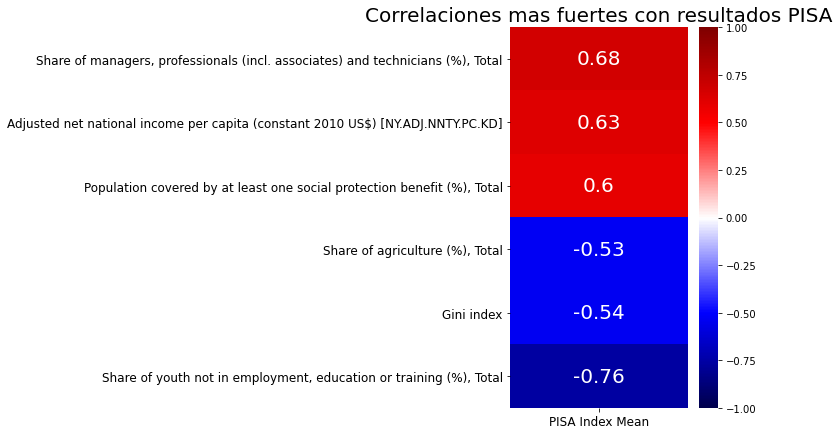

In [13]:
# Tabla correlacion resultados PISA
plt.figure(figsize=(4,7))
sns.heatmap(dftotales[listasi].corr().sort_values('PISA Index Mean', ascending = False)[['PISA Index Mean']].iloc[[1,2,3,-3, -2, -1],:],
           vmin = -1,
           vmax = 1,
           center = 0,
           cmap = 'seismic',
           annot = True,
           annot_kws={"fontsize":20})


plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
plt.title('Correlaciones mas fuertes con resultados PISA',
         fontsize = 20)

# Distribuciones

In [ ]:
for i in dftotales.columns:
    print(i, "\n", sum(dftotales[i].isnull())/len(dftotales), "\n")


Text(0.5, 1.0, 'Distribution de algunas variables clave\ndel mercado laboral entre la muestra de paises')

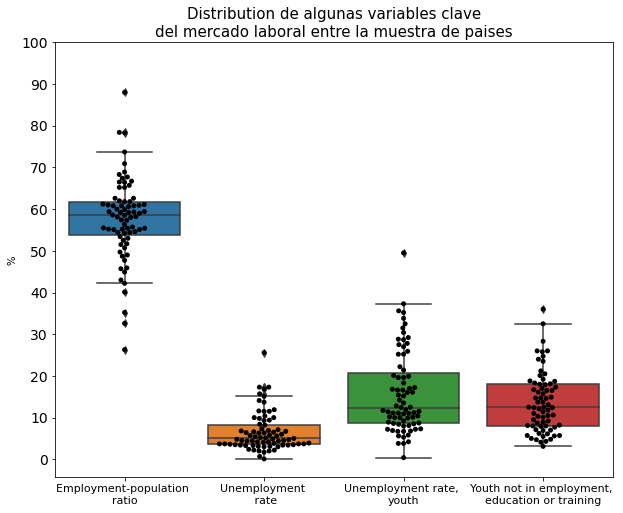

In [14]:

plt.figure(figsize = (10,8))
dftotales_laboral = dftotales[['Employment-population ratio (%), Total',
                       'Unemployment rate (%), Total',
                       "Unemployment rate, youth (%), Total",
                        "Share of youth not in employment, education or training (%), Total"]]

sns.boxplot(data = dftotales_laboral.values)
sns.swarmplot(data = dftotales_laboral.values,
             color = 'k',
             label = dftotales.index.values)
plt.xticks([0,1,2,3], ['Employment-population \nratio',
           'Unemployment \n rate',
           "Unemployment rate, \nyouth",
                        'Youth not in employment, \neducation or training'],
          fontsize = 11)
plt.yticks(list(range(0,110,10)),
          fontsize = 14)
plt.ylabel('%')
plt.title('Distribution de algunas variables clave\ndel mercado laboral entre la muestra de paises',
         fontsize = 15)





<Figure size 864x576 with 0 Axes>

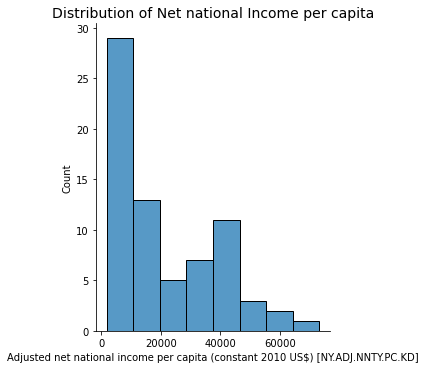

In [15]:
# distribution of income per capita
plt.figure(figsize = (12,8))
sns.displot(data = dftotales, 
            x = "Adjusted net national income per capita (constant 2010 US$) [NY.ADJ.NNTY.PC.KD]");
plt.title('Distribution of Net national Income per capita',
         fontsize = 14);


In [ ]:
for i in dftotales.columns:
    print(i)

Text(0.5, 1.0, 'Distribucion de media por pais para cada prueba')

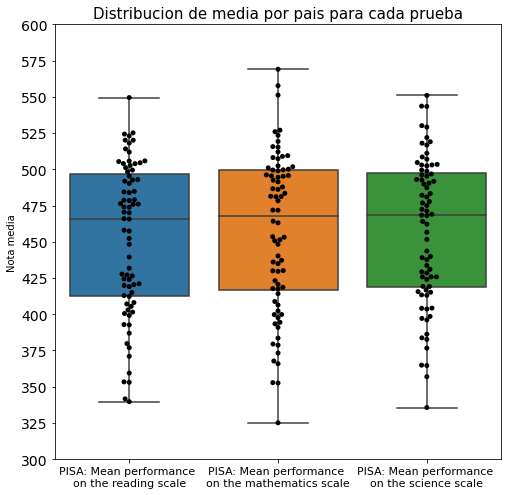

In [16]:
# Distribucion notas PISA sample

dftotales_PISA = dftotales[['PISA: Mean performance on the reading scale [LO.PISA.REA]',
'PISA: Mean performance on the mathematics scale [LO.PISA.MAT]',
'PISA: Mean performance on the science scale [LO.PISA.SCI]']]

plt.figure(figsize = (8,8))
sns.boxplot(data = dftotales_PISA.values)
sns.swarmplot(data = dftotales_PISA.values,
             color = 'k')
plt.xticks([0,1,2], ['PISA: Mean performance \non the reading scale',
           'PISA: Mean performance \non the mathematics scale',
          'PISA: Mean performance \non the science scale'],
          fontsize = 11)
plt.yticks(list(range(300,625,25)),
          fontsize = 14)
plt.ylabel('Nota media')
plt.title('Distribucion de media por pais para cada prueba',
         fontsize = 15)





/opt/anaconda3/lib/python3.8/site-packages/seaborn/axisgrid.py:1629: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  f.tight_layout()


([<matplotlib.axis.YTick at 0x127324d60>,
 <a list of 0 Text major ticklabel objects>)

<Figure size 576x576 with 0 Axes>

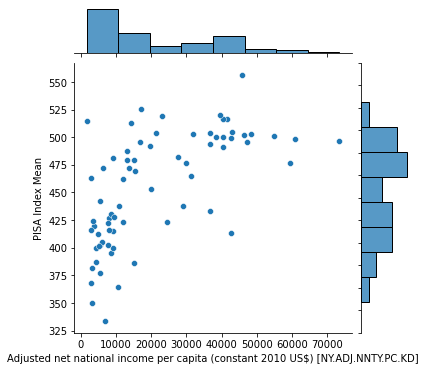

In [17]:

plt.figure(figsize = (8,8))

sns.jointplot(x = dftotales["Adjusted net national income per capita (constant 2010 US$) [NY.ADJ.NNTY.PC.KD]"],
             y = dftotales["PISA Index Mean"])

plt.yticks(list(range(300,625,25)))





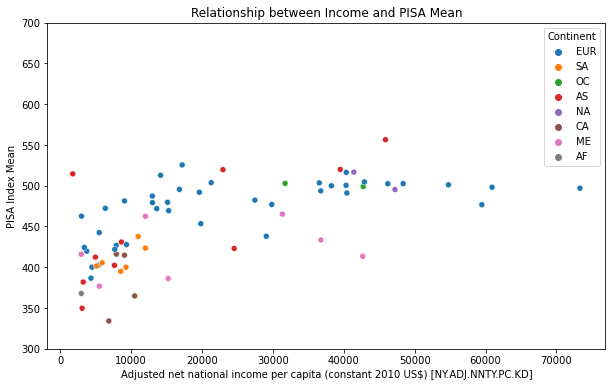

In [18]:
# Scatter Ingresos-PISA mean
plt.figure(figsize = (10,6))
sns.scatterplot(data = dftotales, 
            x="Adjusted net national income per capita (constant 2010 US$) [NY.ADJ.NNTY.PC.KD]", 
                y="PISA Index Mean",
          hue = 'Continent')
plt.ylim(300,700)
plt.title('Relationship between Income and PISA Mean');

In [19]:
# Diferencias porcentuales entre percentiles de notas bajos y altos por paises

dftotales['Dif % Nota p75-p25'] = (((dftotales['PISA: Distribution of Science Scores: 75th Percentile Score [LO.PISA.SCI.P75]']) - \
(dftotales['PISA: Distribution of Science Scores: 25th Percentile Score [LO.PISA.SCI.P25]']))/\
dftotales['PISA: Distribution of Science Scores: 25th Percentile Score [LO.PISA.SCI.P25]'])*(1/3)+\
(((dftotales['PISA: Distribution of Mathematics Scores: 75th Percentile Score [LO.PISA.MAT.P75]']) - \
(dftotales['PISA: Distribution of Mathematics Scores: 25th Percentile Score [LO.PISA.MAT.P25]']))/\
dftotales['PISA: Distribution of Mathematics Scores: 25th Percentile Score [LO.PISA.MAT.P25]'])*(1/3)+\
(((dftotales['PISA: Distribution of Reading Scores: 75th Percentile Score [LO.PISA.REA.P75]']) - \
(dftotales['PISA: Distribution of Reading Scores: 25th Percentile Score [LO.PISA.REA.P25]']))/\
dftotales['PISA: Distribution of Reading Scores: 25th Percentile Score [LO.PISA.REA.P25]'])*(1/3)

dftotales['Dif % Nota p95-5'] = (((dftotales['PISA: Distribution of Science Scores: 95th Percentile Score [LO.PISA.SCI.P95]']) - \
(dftotales['PISA: Distribution of Science Scores: 5th Percentile Score [LO.PISA.SCI.P05]']))/\
dftotales['PISA: Distribution of Science Scores: 5th Percentile Score [LO.PISA.SCI.P05]'])*(1/3)+\
(((dftotales['PISA: Distribution of Mathematics Scores: 95th Percentile Score [LO.PISA.MAT.P95]']) - \
(dftotales['PISA: Distribution of Mathematics Scores: 5th Percentile Score [LO.PISA.MAT.P05]']))/\
dftotales['PISA: Distribution of Mathematics Scores: 5th Percentile Score [LO.PISA.MAT.P05]'])*(1/3)+\
(((dftotales['PISA: Distribution of Reading Scores: 95th Percentile Score [LO.PISA.REA.P95]']) - \
(dftotales['PISA: Distribution of Reading Scores: 5th Percentile Score [LO.PISA.REA.P05]']))/\
dftotales['PISA: Distribution of Reading Scores: 5th Percentile Score [LO.PISA.REA.P05]'])*(1/3)

dftotales['Dif % Nota p90-p10'] = (((dftotales['PISA: Distribution of Science Scores: 90th Percentile Score [LO.PISA.SCI.P90]']) - \
(dftotales['PISA: Distribution of Science Scores: 10th Percentile Score [LO.PISA.SCI.P10]']))/\
dftotales['PISA: Distribution of Science Scores: 10th Percentile Score [LO.PISA.SCI.P10]'])*(1/3)+\
(((dftotales['PISA: Distribution of Mathematics Scores: 90th Percentile Score [LO.PISA.MAT.P90]']) - \
(dftotales['PISA: Distribution of Mathematics Scores: 10th Percentile Score [LO.PISA.MAT.P10]']))/\
dftotales['PISA: Distribution of Mathematics Scores: 10th Percentile Score [LO.PISA.MAT.P10]'])*(1/3)+\
(((dftotales['PISA: Distribution of Reading Scores: 90th Percentile Score [LO.PISA.REA.P90]']) - \
(dftotales['PISA: Distribution of Reading Scores: 10th Percentile Score [LO.PISA.REA.P10]']))/\
dftotales['PISA: Distribution of Reading Scores: 10th Percentile Score [LO.PISA.REA.P10]'])*(1/3)


# Correlaciones entre diferencias de notas, desigualdad economica intrapais e ingresos
dftotales[['Dif % Nota p75-p25', 'Dif % Nota p90-p10', 'Dif % Nota p95-5',  "Gini index",
          'Adjusted net national income per capita (constant 2010 US$) [NY.ADJ.NNTY.PC.KD]']].corr()

<ipython-input-19-38b88bf251af>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dftotales['Dif % Nota p75-p25'] = (((dftotales['PISA: Distribution of Science Scores: 75th Percentile Score [LO.PISA.SCI.P75]']) - \
<ipython-input-19-38b88bf251af>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dftotales['Dif % Nota p95-5'] = (((dftotales['PISA: Distribution of Science Scores: 95th Percentile Score [LO.PISA.SCI.P95]']) - \
<ipython-input-19-38b88bf251af>:23: SettingWithCopyWarning: 
A value is trying to be 

,Dif % Nota p75-p25,Dif % Nota p90-p10,Dif % Nota p95-5,Gini index,Adjusted net national income per capita (constant 2010 US$) [NY.ADJ.NNTY.PC.KD]
Dif % Nota p75-p25,1.000000,0.993686,0.981431,0.255092,-0.040045
Dif % Nota p90-p10,0.993686,1.000000,0.996089,0.251429,-0.042865
Dif % Nota p95-5,0.981431,0.996089,1.000000,0.253244,-0.059481
Gini index,0.255092,0.251429,0.253244,1.000000,-0.339248
Adjusted net national income per capita (constant 2010 US$) [NY.ADJ.NNTY.PC.KD],-0.040045,-0.042865,-0.059481,-0.339248,1.000000


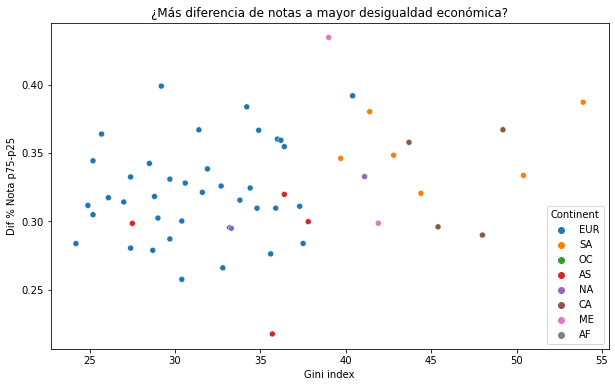

In [20]:
# Scatter para ver graficamente relacion entre desigualdad economica intrapais y diferencias de notas entre
# percentil bajo y alto
plt.figure(figsize = (10,6))
sns.scatterplot(data = dftotales, 
            x="Gini index", 
                y="Dif % Nota p75-p25",
          hue = 'Continent')
plt.title('¿Más diferencia de notas a mayor desigualdad económica?');

In [ ]:
for i in dfgenero.columns:
    print(i)

In [21]:
dfgenero = df.droplevel(0, axis=1)

In [22]:
# Variables para ver diferencias de genero por pais
dfgenero["Diferencia mates (M-F)/F"] = ((dfgenero['PISA: Mean performance on the mathematics scale. Male [LO.PISA.MAT.MA]']-
dfgenero['PISA: Mean performance on the mathematics scale. Female [LO.PISA.MAT.FE]'])\
/dfgenero['PISA: Mean performance on the mathematics scale. Female [LO.PISA.MAT.FE]'])

dfgenero["Diferencia read (M-F)/F"] = ((dfgenero['PISA: Mean performance on the reading scale. Male [LO.PISA.REA.MA]']-
dfgenero['PISA: Mean performance on the reading scale. Female [LO.PISA.REA.FE]'])\
/dfgenero['PISA: Mean performance on the reading scale. Female [LO.PISA.REA.FE]'])

dfgenero["Diferencia science (M-F)/F"] = ((dfgenero['PISA: Mean performance on the science scale. Male [LO.PISA.SCI.MA]']-
dfgenero['PISA: Mean performance on the science scale. Female [LO.PISA.SCI.FE]'])\
/dfgenero['PISA: Mean performance on the science scale. Female [LO.PISA.SCI.FE]'])

In [23]:
dfgenero["Diferencia mates (M-F)/F"].sort_values()

Code  Country     
QAT   Qatar          -0.056253
THA   Thailand       -0.037488
SAU   Saudi Arabia   -0.034340
PHL   Philippines    -0.032532
MLT   Malta          -0.026817
                        ...   
ARG   Argentina       0.041498
PER   Peru            0.041708
CRI   Costa Rica      0.044886
COL   Colombia        0.051189
VNM   Viet Nam             NaN
Name: Diferencia mates (M-F)/F, Length: 77, dtype: float64

/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-lev

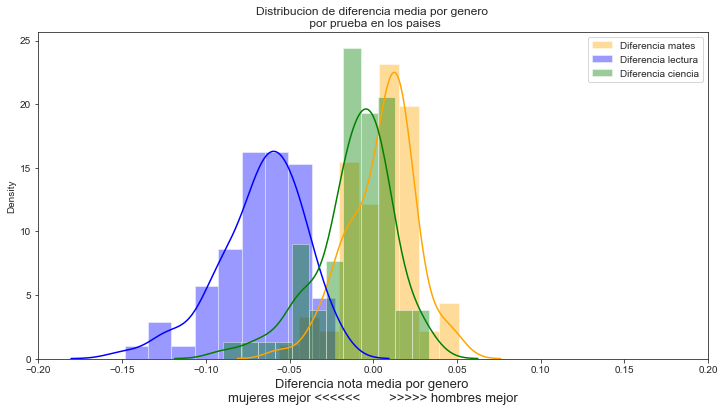

In [33]:
# Genero

plt.figure(figsize = (12,6))
sns.distplot( dfgenero["Diferencia mates (M-F)/F"] , color="orange", label="Diferencia mates")
sns.distplot( dfgenero["Diferencia read (M-F)/F"] , color="blue", label="Diferencia lectura")
sns.distplot( dfgenero["Diferencia science (M-F)/F"] , color="green", label="Diferencia ciencia")
plt.xlabel('Diferencia nota media por genero \n\
mujeres mejor <<<<<<        >>>>> hombres mejor',
          fontsize = 13)
plt.xlim(-0.2, 0.2)
plt.title('Distribucion de diferencia media por genero \n por prueba en los paises')
plt.legend()


In [26]:
diferencias = dfgenero[["Diferencia read (M-F)/F",
         "Diferencia science (M-F)/F",
         "Diferencia mates (M-F)/F"]].describe()
diferencias = diferencias.transpose() *100


In [ ]:
diferencias

AttributeError: 'PolyCollection' object has no property 'x2'

<Figure size 1368x720 with 0 Axes>

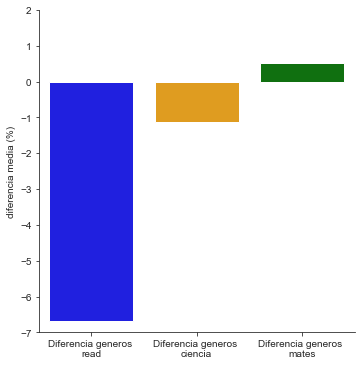

In [44]:
clrs = {diferencias.index[0]: "blue",
       diferencias.index[1]: "orange",
       diferencias.index[2]: "green"}
plt.figure(figsize = (19,10))
sns.catplot(data = diferencias,
    x = diferencias.index,
           y = 'mean',
           kind = 'bar',
           palette = clrs)

plt.xticks([0, 1, 2], ['Diferencia generos \nread', 
                       'Diferencia generos \nciencia',
                      'Diferencia generos \nmates'])

plt.ylabel("diferencia media (%)")

plt.ylim(-7, 2, 0.5)

plt.fill_between(x=(0,-0.07), y1=3, x2=3,
                                  
                 color="#e0eaf3", zorder=0 )






Text(0.5, 1.0, 'Media diferencias por genero - conjunto de paises')

<Figure size 1368x720 with 0 Axes>

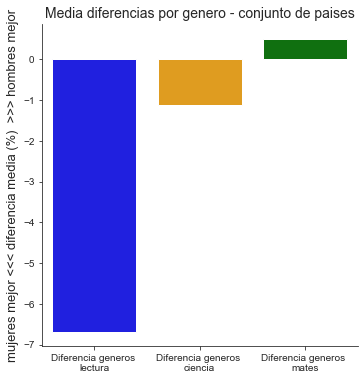

In [31]:
sns.set_style('ticks')
clrs = {diferencias.index[0]: "blue",
       diferencias.index[1]: "orange",
       diferencias.index[2]: "green"}
plt.figure(figsize = (19,10))
sns.catplot(data = diferencias,
    x = diferencias.index,
           y = 'mean',
           kind = 'bar',
           palette = clrs);

plt.xticks([0, 1, 2], ['Diferencia generos \nlectura', 
                       'Diferencia generos \nciencia',
                      'Diferencia generos \nmates'])

plt.ylabel("mujeres mejor <<< diferencia media (%)  >>> hombres mejor",
          fontsize = 13)
plt.title("Media diferencias por genero - conjunto de paises",
         fontsize = 14)






In [36]:
dfgenero ['Diferencia Genero Global (M-F)/F'] = dfgenero["Diferencia mates (M-F)/F"]*(1/3)+\
dfgenero["Diferencia read (M-F)/F"]*(1/3)+\
dfgenero["Diferencia science (M-F)/F"]*(1/3)

/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


(-0.2, 0.2)

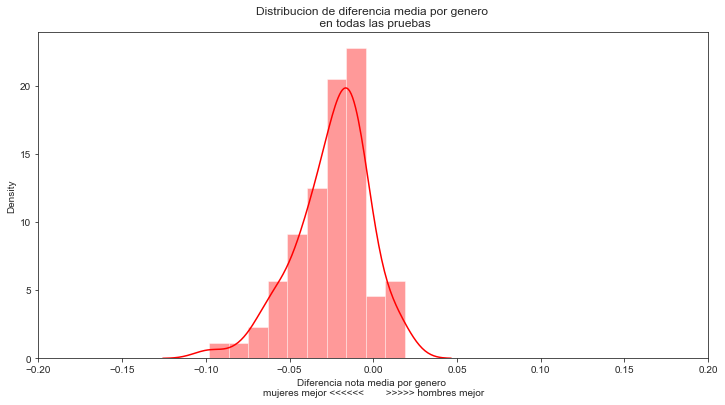

In [37]:
# Diferencias genero indice 3 asignatuas
dfgenero ['Diferencia Genero Global (M-F)/F']
plt.figure(figsize = (12,6))


sns.distplot( dfgenero ['Diferencia Genero Global (M-F)/F'], color="red", label="Diferencia Genero Global")

plt.xlabel('Diferencia nota media por genero \n\
mujeres mejor <<<<<<        >>>>> hombres mejor')

plt.title('Distribucion de diferencia media por genero \n en todas las pruebas')
plt.xlim(-0.2, 0.2)

In [38]:
# correlacion diferencia genero global con ingresos
dfgenero.corr()[["Diferencia Genero Global (M-F)/F"]].sort_values("Diferencia Genero Global (M-F)/F", ascending = False)\
.loc['Adjusted net national income per capita (constant 2010 US$) [NY.ADJ.NNTY.PC.KD]', :]

Diferencia Genero Global (M-F)/F    0.000249
Name: Adjusted net national income per capita (constant 2010 US$) [NY.ADJ.NNTY.PC.KD], dtype: float64

Text(0.5, 1.0, 'Correlaciones con diferencias educativas de genero')

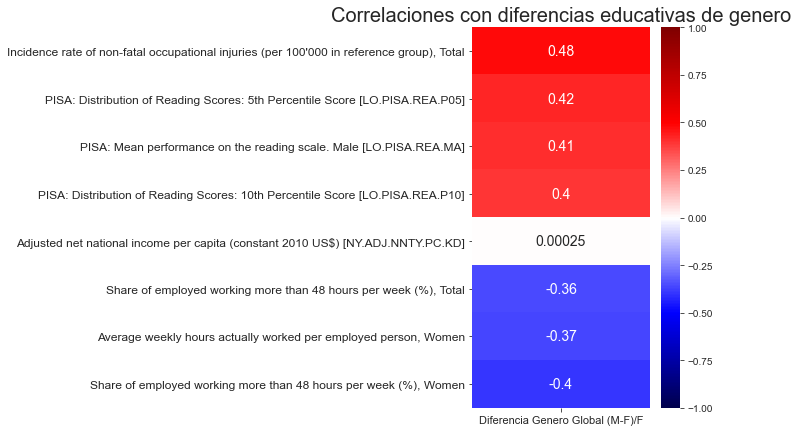

In [39]:
# correlaciones mas fuertes de diferencia genero global
plt.figure(figsize=(4,7))
sns.heatmap(dfgenero.corr()[["Diferencia Genero Global (M-F)/F"]].sort_values("Diferencia Genero Global (M-F)/F", ascending = False)\
.iloc[[4,5,6,7,70,-9,-8,-7],:],
            vmin = -1,
           vmax = 1,
           center = 0,
           cmap = 'seismic',
           annot = True,
           annot_kws={"fontsize" : 14})


plt.xticks(fontsize = 11)
plt.yticks(fontsize = 12)
plt.title('Correlaciones con diferencias educativas de genero',
         fontsize = 20)